# Traffic Time Series Forcasting- Minneapolis/St.Paul
#### Brandon Polk

This project was a part of the spring 2021 CSC 578 Neural Networks and Deep Learning final at DePaul University, and was setup as a kaggle competition. The goal is to create a recurrent neural network capable of reliably predicting future traffic volume using time series data of traffic in the Minneapolis/St.Paul area. The results of this project finished 8th out of 46 total entries in the competition.

This notebook contains a description and exploration of the traffic data, data preprocessing, code setup for the model, samples of model optimization, and an evaluation of the best performing model. 

## Library Imports (same as tutorial)

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.keras.utils.set_random_seed(27)

## Data: Minneapolis/St.Paul Traffic Time Series
This notebook uses a <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz" class="external">traffic time series dataset</a> recorded by the <a href="https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#" class="external">John Hogue Social Data Science & General Mills</a>.

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume. 9 attributes, 48,000+ samples

**holiday-** Categorical US National holidays plus regional holiday, Minnesota State Fair <br>
**temp-** Numeric Average temp in kelvin <br>
**rain_1h-** Numeric Amount in mm of rain that occurred in the hour <br>
**snow_1h-** Numeric Amount in mm of snow that occurred in the hour <br>
**clouds_all-** Numeric Percentage of cloud cover <br>
**weather_main-** Categorical Short textual description of the current weather <br>
**weather_description-** Categorical Longer textual description of the current weather <br>
**date_time-** DateTime Hour of the data collected in local CST time <br>
**traffic_volume**- Numeric Hourly I-94 ATR 301 reported westbound traffic volume

Downloading data

In [3]:
data_url= 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'
data_name= 'Metro_Interstate_Traffic_Volume.csv.gz'
home_dir= os.getcwd()

In [4]:
zip_path = tf.keras.utils.get_file(
    origin= data_url,
    fname= data_name,
    cache_dir= home_dir,
    cache_subdir= 'data')

zip_path

'C:\\Users\\bspol\\Documents\\Career\\Data Science-Analytics\\Portfolio Projects\\Deep Learning\\data\\Metro_Interstate_Traffic_Volume.csv.gz'

Creating dataframe from csv data and collecting the date times of the samples 

In [5]:
df = pd.read_csv(zip_path, compression="gzip")

date_time = pd.to_datetime(df.pop('date_time'), format='%Y-%m-%d %H:%M:%S')

## Data Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


Let's take a glance at the data. Here are the first few rows:

In [7]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [8]:
#5-Point Summary and Frequency information
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
holiday,48204,12,None,48143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,48204.0,NaN,NaN,NaN,281.20587,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,NaN,NaN,NaN,0.334264,44.789133,0.0,0.0,0.0,0.0,9831.3
snow_1h,48204.0,NaN,NaN,NaN,0.000222,0.008168,0.0,0.0,0.0,0.0,0.51
clouds_all,48204.0,NaN,NaN,NaN,49.362231,39.01575,0.0,1.0,64.0,90.0,100.0
weather_main,48204,11,Clouds,15164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather_description,48204,38,sky is clear,11665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traffic_volume,48204.0,NaN,NaN,NaN,3259.818355,1986.86067,0.0,1193.0,3380.0,4933.0,7280.0


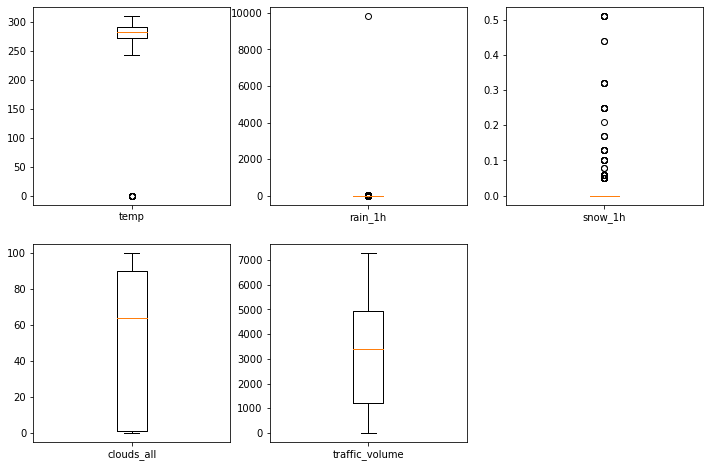

In [9]:
#Boxplots of numerical variables
cols= ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']

fig,axs= plt.subplots(nrows=2, ncols=3, figsize= (12,8))
axs= axs.flatten()
for i, c in enumerate(cols):
    axs[i].boxplot(df[c], labels= [c])
axs[-1].axis('off')
plt.show()

Intersting things to note here: <br>
1) Temperature is measured in kelvins, so a temp of 0 is absolute zero. Absolute zero is not a possible temperature in this context, so any sample with this value is likely missing data and must be dealt with appropriately. <br>

2) There is a severe outlier in rain_1h. It has a max value of 9831.3 mm which would be an excessive amount of rainfall in a single hour, far beyond what would be considered possible. <br>

3) There are several categorical variables that may need to be transformed into numerical representations to be used in the predictive RNN model.

These issues will be rectified before we use the data in any models.

#### Fixing temp outlier

The 0 temp values within the data will be replaced by the mean temperatures at that hour in the rest of the data

In [10]:
#Index of outlier temp values
temp0= df[df['temp']== 0].index
temp0

Int64Index([11898, 11899, 11900, 11901, 11946, 11947, 11948, 11949, 11950,
            11951],
           dtype='int64')

In [11]:
#View data with 0 temperature
df.iloc[temp0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,361
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,734
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2557
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,5150
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,291
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,284
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,434
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,739
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,962
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,1670


Each instance of the data where the temperature is recorded as 0 has a weather_description and weather_main of 'sky is clear' and 'Clear' respectively. The outlier temp data will be replaced with the mean temperature of the other samples that share those weather values and were recorded at the same hour.

In [12]:
#Gathering indices of data with Clear and Sky is Clear weather and temperature > 0
id_clear= df[(df['weather_main']== 'Clear') & 
             (df['weather_description']== 'sky is clear') &
            (df['temp']> 0)].index

#Gather all datetimes from samples with a recorded temperature > 0 and clear weather
dt_warm= date_time.iloc[id_clear]

In [13]:
#Replacing 0 temperature values with mean of temperature at that hour throughout the rest of the data
#Only samples with a recorded temperature above 0 and matching weather are used to calculate the mean

for i in temp0:
  h= date_time.iloc[i].hour
  m= df.iloc[dt_warm[dt_warm.dt.hour== h].index]['temp'].mean()
  df.at[i,'temp']= m

In [14]:
#Data where temperature was 0 has been replaced
df.iloc[temp0]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
11898,None,277.125323,0.0,0.0,0,Clear,sky is clear,361
11899,None,276.368520,0.0,0.0,0,Clear,sky is clear,734
11900,None,276.469402,0.0,0.0,0,Clear,sky is clear,2557
11901,None,274.874563,0.0,0.0,0,Clear,sky is clear,5150
11946,None,277.125323,0.0,0.0,0,Clear,sky is clear,291
11947,None,276.368520,0.0,0.0,0,Clear,sky is clear,284
11948,None,276.469402,0.0,0.0,0,Clear,sky is clear,434
11949,None,274.874563,0.0,0.0,0,Clear,sky is clear,739
11950,None,275.243965,0.0,0.0,0,Clear,sky is clear,962
11951,None,276.857434,0.0,0.0,0,Clear,sky is clear,1670


#### Fixing rain outlier

The 1 rain outlier within the data will be replaced with the average amount of rain for that hour throughout the rest of the data

In [15]:
#Index of outlier rain value
df[df['rain_1h']== 9831.3].index

Int64Index([24872], dtype='int64')

In [16]:
# Findind the timestamp hour of the rain outlier
date_time.iloc[24872].hour

17

In [17]:
#Finding the mean of the rain value for all other data collected at hour 17
dt_rain= date_time[date_time.index!=24872]
h17_rain= df.iloc[dt_rain[dt_rain.dt.hour== 17].index]['rain_1h'].mean()

#Replacing the outlier
df.at[24872, 'rain_1h']= h17_rain

The obvious outliers have been addressed: 

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.263164,12.708485,243.39,272.19,282.45,291.806,310.07
rain_1h,48204.0,0.130315,1.003368,0.00,0.00,0.00,0.000,55.63
snow_1h,48204.0,0.000222,0.008168,0.00,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.00,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.00,1193.00,3380.00,4933.000,7280.00


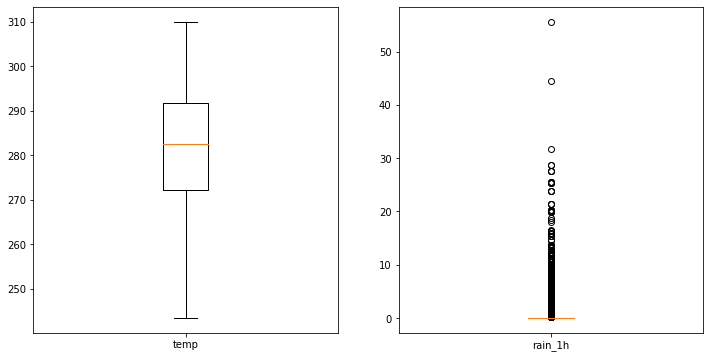

In [19]:
#Boxplots of temp and rain_1h with extreme outliers removed
fig,(ax1,ax2)= plt.subplots(nrows=1, ncols=2, figsize= (12,6))
ax1.boxplot(df['temp'], labels= ['temp'])
ax2.boxplot(df['rain_1h'], labels= ['rain_1h'])
plt.show()

#### Visualizing features over time

Temp

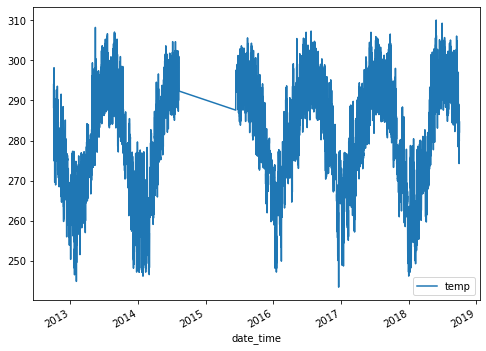

In [20]:
#Visualizing temp over time
plot_cols = ['temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot()

Based on this time plot, there appears to be a notable gap in the data spanning from dates in 2014 thru 2015. This missing/invalid data may cause issues in model performance later on.

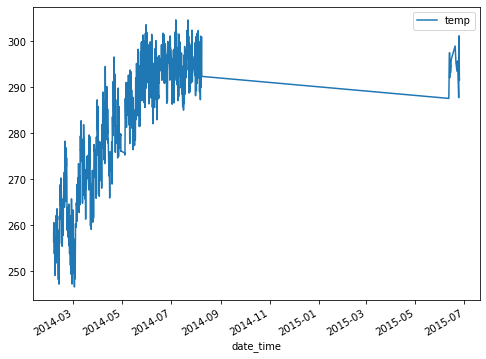

In [21]:
# Closer look at the data gap
plot_cols = ['temp']
plot_features = df[plot_cols][12000:16000]
plot_features.index = date_time[12000:16000]
_ = plot_features.plot(subplots=True)

The gap in data appears to span from 2014-08 to 2015-06 

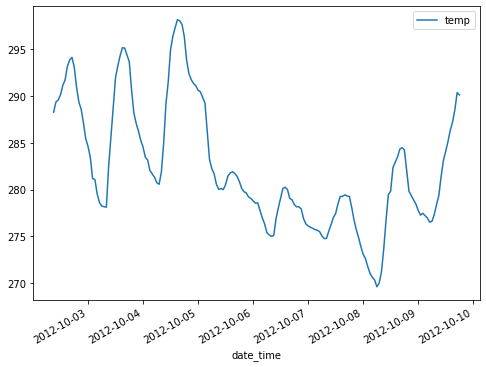

In [22]:
# Closer look at temp data (1 week)
plot_cols = ['temp']
plot_features = df[plot_cols][:168]
plot_features.index = date_time[:168]
_ = plot_features.plot(subplots=True)

As expected, the temperature fluctuates from highs to lows in a regular pattern throughout the day.

Rain_1h

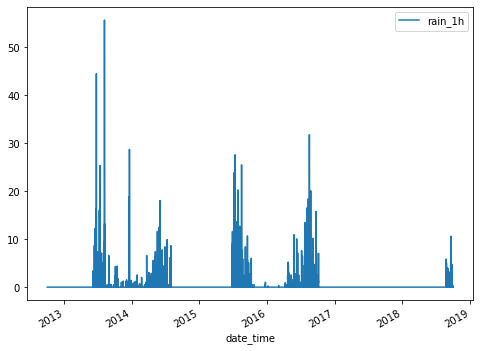

In [23]:
#Visualizing rain_1h over time
plot_cols = ['rain_1h']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot()

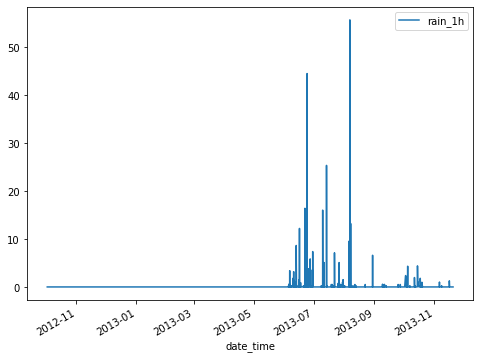

In [24]:
# Closer look at portion of rain_1h
plot_cols = ['rain_1h']
plot_features = df[plot_cols][:10000]
plot_features.index = date_time[:10000]
_ = plot_features.plot(subplots=True)

The rain_1h data appears to have some inconsistancies. While yearly rainfall should vary from year to year, there one would expect there to be some general pattern of seasonal rainfall. While there is some pattern, rainfall tends to happen towards the middle and later half of the year, there is a notable lack of recorded rainfall that spans several years, including the period of missing data noted earlier. The data collection for this attribute may have been inconsistent over time. 

Snow_1h

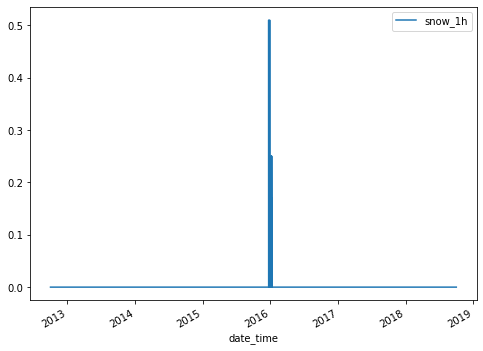

In [25]:
#Visualizing snow_1h over time
plot_cols = ['snow_1h']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot()

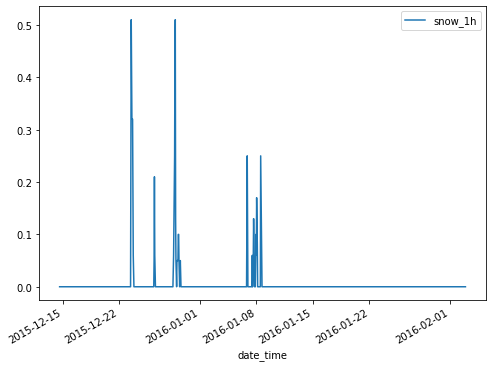

In [26]:
# Closer look at portion of snow_1h
plot_cols = ['snow_1h']
plot_features = df[plot_cols][20000:21000]
plot_features.index = date_time[20000:21000]
_ = plot_features.plot(subplots=True)

Again there appears to be a significant lack of data collected for snowfall. Given that this data was collected in the minneapolis/st.paul region, it is highly unlikely that there was not more snowfall recorded over the period of time for which we have data. Whether or not this variable is ultimately included in the model will depend on its performance.

Clouds_all

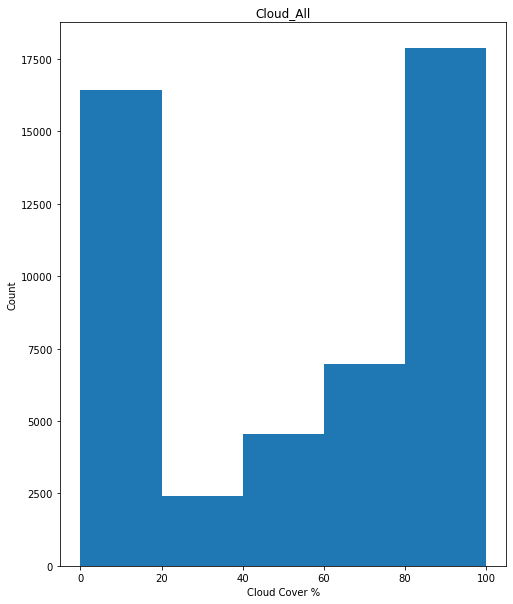

In [27]:
#Histogram showing distribution of cloud_all variable
plt.figure(figsize= (8,10))
plt.hist(df['clouds_all'], bins=5)
plt.xlabel('Cloud Cover %')
plt.ylabel('Count')
plt.title('Cloud_All')
plt.show()

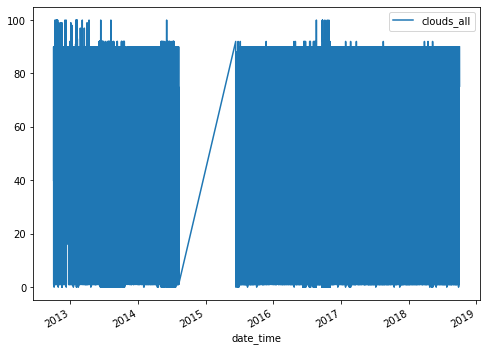

In [28]:
#Visualizing clouds_all over time
plot_cols = ['clouds_all']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot()

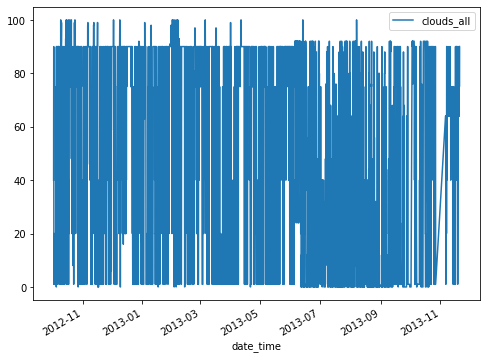

In [29]:
# Closer look at portion of clouds_all
plot_cols = ['clouds_all']
plot_features = df[plot_cols][:10000]
plot_features.index = date_time[:10000]
_ = plot_features.plot(subplots=True)

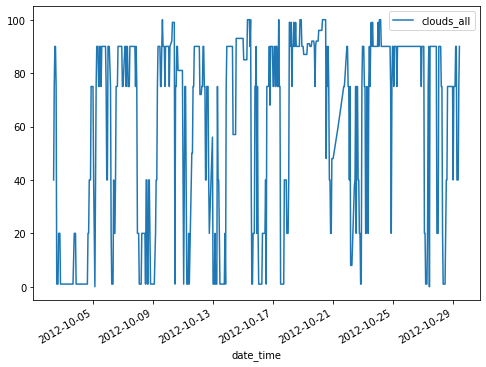

In [30]:
# Closer look at portion of clouds_all (1 month)
plot_cols = ['clouds_all']
plot_features = df[plot_cols][:744]
plot_features.index = date_time[:744]
_ = plot_features.plot(subplots=True)

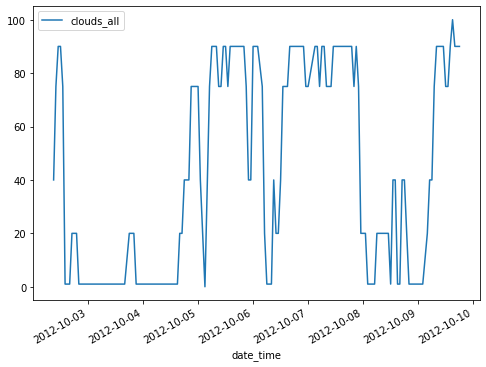

In [31]:
# Closer look at portion of clouds_all (1 week)
plot_cols = ['clouds_all']
plot_features = df[plot_cols][:168]
plot_features.index = date_time[:168]
_ = plot_features.plot(subplots=True)

The cloud data appears to vary regularly over periods of time. However, as indicated by the histogram, the vast majority of samples have either no cloud cover or total cloud cover recorded.

Traffic_volume

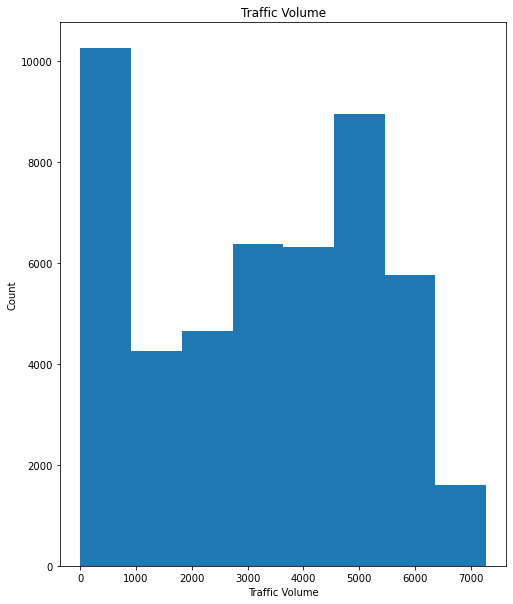

In [32]:
#Histogram showing distribution of traffic_volume variable
plt.figure(figsize= (8,10))
plt.hist(df['traffic_volume'], bins=8)
plt.xlabel('Traffic Volume')
plt.ylabel('Count')
plt.title('Traffic Volume')
plt.show()

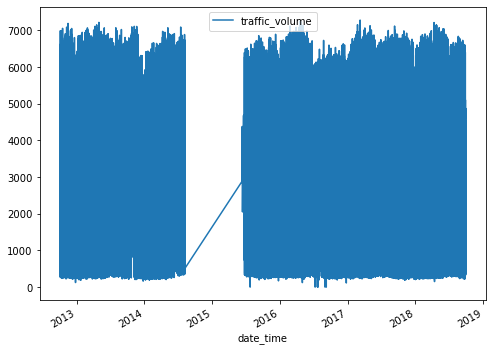

In [33]:
#Traffic Volume over time
plot_cols = ['traffic_volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

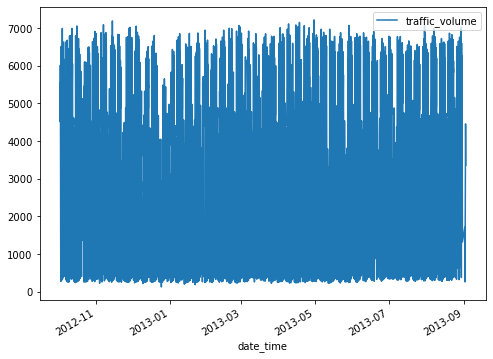

In [34]:
#A closer look at traffic volume (1 year)
plot_cols = ['traffic_volume']
plot_features = df[plot_cols][:8760]
plot_features.index = date_time[:8760]
_ = plot_features.plot(subplots=True)

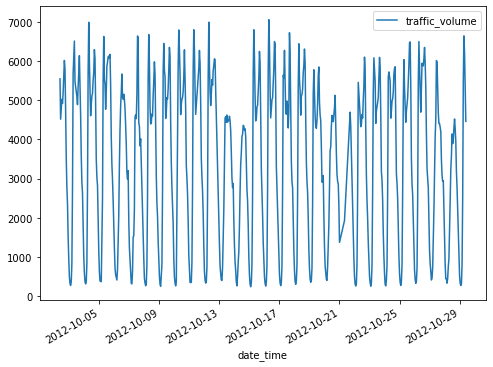

In [35]:
#A closer look at traffic volume (1 month)
plot_cols = ['traffic_volume']
plot_features = df[plot_cols][:744]
plot_features.index = date_time[:744]
_ = plot_features.plot(subplots=True)

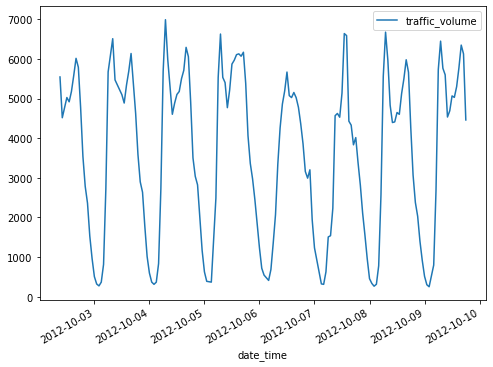

In [36]:
#A closer look at traffic volume (1 week)
plot_cols = ['traffic_volume']
plot_features = df[plot_cols][:168]
plot_features.index = date_time[:168]
_ = plot_features.plot(subplots=True)

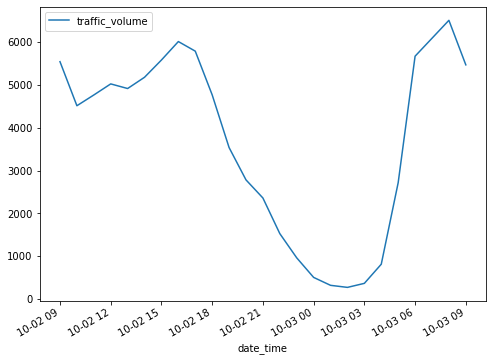

In [37]:
#A closer look at traffic volume (1 day)
plot_cols = ['traffic_volume']
plot_features = df[plot_cols][:24]
plot_features.index = date_time[:24]
_ = plot_features.plot(subplots=True)

#### Exploring Categorical Data: Holiday, Weather_main, Weather_description

In [38]:
df[['holiday','weather_main','weather_description']].describe(include='all').transpose()

,count,unique,top,freq
holiday,48204,12,None,48143
weather_main,48204,11,Clouds,15164
weather_description,48204,38,sky is clear,11665


Holiday <br>
Contains 12 unique values

In [39]:
df['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [40]:
df['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

Weather_main <br>
This attribute contains 11 unique values

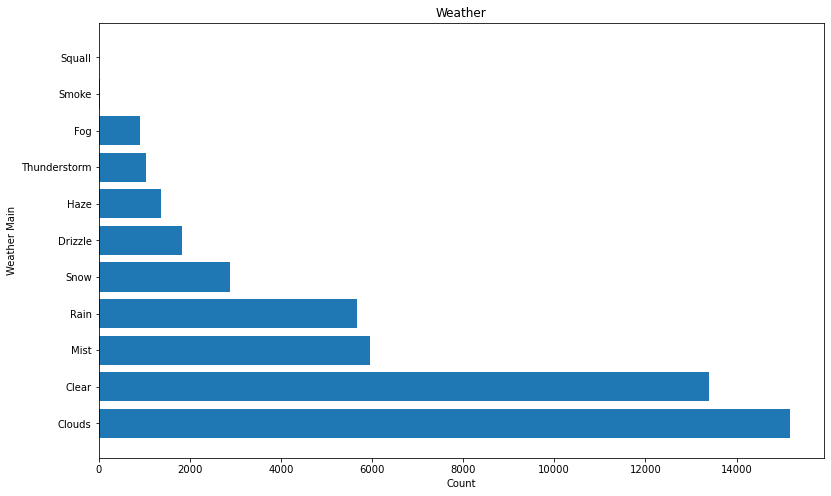

In [41]:
#Barplot showing counts of weather_main values
val_counts= df['weather_main'].value_counts()
vals= val_counts.index

fig,ax = plt.subplots(figsize=(13,8))
ax.barh(vals, val_counts)
ax.set_ylabel('Weather Main')
ax.set_xlabel('Count')
ax.set_title('Weather')
plt.show()

In [42]:
df['weather_main'].value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

Weather_description <br>
Contains 38 unique values

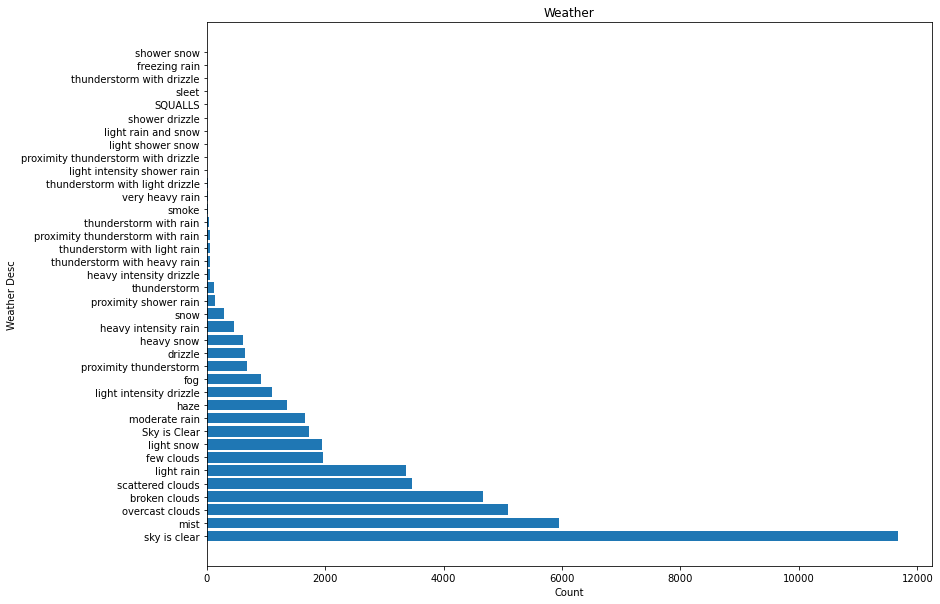

In [43]:
val_counts= df['weather_description'].value_counts()
vals= val_counts.index

fig,ax = plt.subplots(figsize=(13,10))
ax.barh(vals, val_counts)
ax.set_ylabel('Weather Desc')
ax.set_xlabel('Count')
ax.set_title('Weather')
plt.show()

In [44]:
df['weather_description'].value_counts()

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

## Data Pre-Processing

### Feature Creation: Time of Day and Time of Year

The datetime for each sample will be converted into signals representing the time of day and the time of year. This is done so that the dates can be used by the model, giving it the chance to pick up cyclical patterns in the data related to days (time of day) and years (time of year).

In [45]:
#This creates a timestamp of each recorded date
timestamp_s = date_time.map(datetime.datetime.timestamp)

Converting datetimes with `sin` and `cos` to clear "Time of day" and "Time of year" signals:

In [46]:
#Converting timestamps into usable signals for 'time of day' and 'time of year'
day = 24*60*60
year = (365.2425)*day

#Creating time signal features
#The period of sin/cos function represents a full day. 
#Dividing it by the number of seconds in a day, multiplying the result by our timestamp, and applying sin/cos will result in the time's position in the daily cycle 
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

#Same as day, but for year
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

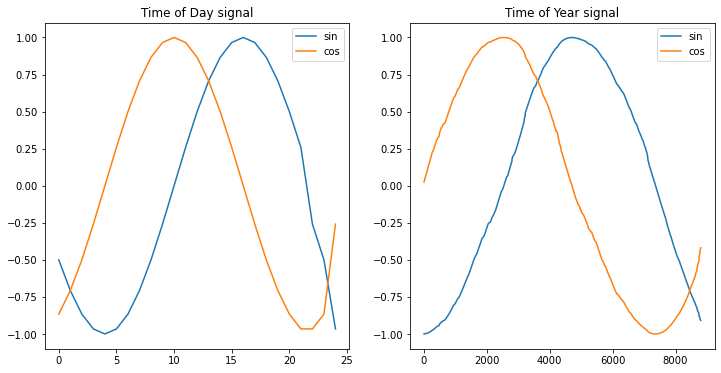

In [47]:
#Visualizing day and year time signals
fig,(ax1,ax2)= plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax1.plot(np.array(df['Day sin'])[:25], label= 'sin')
ax1.plot(np.array(df['Day cos'])[:25], label= 'cos')
ax1.set_title('Time of Day signal')
ax1.legend()

ax2.plot(np.array(df['Year sin'])[:8800], label= 'sin')
ax2.plot(np.array(df['Year cos'])[:8800], label= 'cos')
ax2.set_title('Time of Year signal')
ax2.legend()

plt.show()

### Encoding Categorical Variables

To utilize the categorical values, they must be converted to numerical representations. Weather_main and weather_description describe the same aspect of the data with different specificity. The weather_main feature is the more general of the two, but the categories are distinct enough to be useful for the analysis. As such, the weather_description feature will be discarded in favor of weather_main.

In [48]:
#Removing weather_description feature from data
df_main = df.loc[:, df.columns!= 'weather_description'].copy()

In [49]:
df_main.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,Day sin,Day cos,Year sin,Year cos
0,None,288.28,0.0,0.0,40,Clouds,5545,-0.500000,-8.660254e-01,-0.999682,0.025224
1,None,289.36,0.0,0.0,75,Clouds,4516,-0.707107,-7.071068e-01,-0.999663,0.025941
2,None,289.58,0.0,0.0,90,Clouds,4767,-0.866025,-5.000000e-01,-0.999645,0.026658
3,None,290.13,0.0,0.0,90,Clouds,5026,-0.965926,-2.588190e-01,-0.999625,0.027374
4,None,291.14,0.0,0.0,75,Clouds,4918,-1.000000,5.575167e-13,-0.999605,0.028091


#### Creating Dummy Variables for Categorical Data

In [50]:
#Creating dummy variables
df_main= pd.get_dummies(df_main)

In [51]:
df_main.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos,holiday_Christmas Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,288.28,0.0,0.0,40,5545,-0.500000,-8.660254e-01,-0.999682,0.025224,0,...,1,0,0,0,0,0,0,0,0,0
1,289.36,0.0,0.0,75,4516,-0.707107,-7.071068e-01,-0.999663,0.025941,0,...,1,0,0,0,0,0,0,0,0,0
2,289.58,0.0,0.0,90,4767,-0.866025,-5.000000e-01,-0.999645,0.026658,0,...,1,0,0,0,0,0,0,0,0,0
3,290.13,0.0,0.0,90,5026,-0.965926,-2.588190e-01,-0.999625,0.027374,0,...,1,0,0,0,0,0,0,0,0,0
4,291.14,0.0,0.0,75,4918,-1.000000,5.575167e-13,-0.999605,0.028091,0,...,1,0,0,0,0,0,0,0,0,0


In [52]:
df_main.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume', 'Day sin',
       'Day cos', 'Year sin', 'Year cos', 'holiday_Christmas Day',
       'holiday_Columbus Day', 'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King Jr Day', 'holiday_Memorial Day',
       'holiday_New Years Day', 'holiday_None', 'holiday_State Fair',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day',
       'holiday_Washingtons Birthday', 'weather_main_Clear',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Haze', 'weather_main_Mist', 'weather_main_Rain',
       'weather_main_Smoke', 'weather_main_Snow', 'weather_main_Squall',
       'weather_main_Thunderstorm'],
      dtype='object')

### Spliting the data: Train, Validation, Test

The last 5000 samples will be used as a test set. The other records will have a training-test split of 80-20 

Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

#### Splitting df_main

In [53]:
#Splitting df_main dataset
#Test data
test_df_main= df_main[-5000:].copy()
print(f'# of Test Observations: {len(test_df_main)}')

#Total remaining data
n= len(df_main) - 5000

#Training data
train_df_main= df_main[0:int(n*.8)].copy()
print(f'# of Training Observations: {len(train_df_main)}')

#Validation data
val_df_main= df_main[int(n*.8):-5000].copy()
print(f'# of Validation Observations: {len(val_df_main)}')

# of Test Observations: 5000
# of Training Observations: 34563
# of Validation Observations: 8641


### Normalize the data: Min-Max (0,1)

It is important to scale features before training a neural network so that no variable has outsized influence on the model due to its scale of measurement. Min-Max normalization transforming the data to values between 0 and 1 will be applied because the data includes several categorical features that do not follow a guassian distribution. This will ensure that all values within the dataset are on the same scale. To implement min-max scaling, the minimum value of a variable is subtracted from each value and the result is divided by the range (max - min) of that variable to produce the normalized value. Normalization was not applied to the time of day/year variables in order to maintain their integrity and because they already exist at an acceptable scale. 

Only the training data will be used to scale the data. This is to ensure that model does not inadvertantly pick up information about the validation and test data during training. 

#### Normalization: df_main

In [54]:
#Applying min-max scaling to df_main (except for time of day signals)
#Collecting all non-time of day columns
norm_cols= [c for c in train_df_main.columns if c not in ['Day sin', 'Day cos', 'Year sin', 'Year cos']]

#Collecting min, max, and range values for each variable
train_min= train_df_main[norm_cols].min()
train_max= train_df_main[norm_cols].max()
mm_range= train_max - train_min

#Applying min-max scaling to the data
train_df_main.loc[:, norm_cols]= (train_df_main[norm_cols] - train_min) / mm_range
val_df_main.loc[:, norm_cols]= (val_df_main[norm_cols] - train_min) / mm_range
test_df_main.loc[:, norm_cols]= (test_df_main[norm_cols] - train_min) / mm_range

In [55]:
#Verifying Min-Max scaling
train_df_main.loc[:,'temp':'Year cos'].describe().T[['min','max']]

,min,max
temp,0.0,1.0
rain_1h,0.0,1.0
snow_1h,0.0,1.0
clouds_all,0.0,1.0
traffic_volume,0.0,1.0
Day sin,-1.0,1.0
Day cos,-1.0,1.0
Year sin,-1.0,1.0
Year cos,-1.0,1.0


## Data windowing

The RNN model will make a set of predictions of traffic volume based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

The following section focuses on implementing the data windowing to prepare the data for use in the neural network. The following class definition for generating windows of data was borrowed from a neural network tutorial found at https://www.tensorflow.org/tutorials/structured_data/time_series. It has been modified for use within this project and commented to help with understanding how the WindowGenerator class works. 


The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### WindowGenerator class from tutorial

Comments marked (bp) are my own notes

In [204]:

class WindowGenerator():
  #(bp) Input_width: the number of timesteps that go into the model as input
  #(bp) label_width: the number of timesteps the model is expected to output
  #(bp) shift: how many timesteps into the future the model is asked to predict
  #(bp) train_df: the train set of data
  #(bp) val_df: the validation set of data
  #(bp) test_df: the test set of data
  #(bp) label_columns: A list of the column names (strings) whose values the model will use as labels and predict
  #(bp) **NOTE** train_df, val_df, and test_df are no longer hardcoded as defaults of this class. If different variable names are used for the training, validation, and test dataframes, they muct be manually input as arguments. 
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      #(bp) Indices of the columns to be predicted in the 'label_columns' argument are collected in a dictionary
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    #(bp) Indices of the columns to be predicted in the training dataframe are collected in a dictionary
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    #(bp) Portion of window size that is input and the indices of the input timesteps in that window
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    #(bp) Location of total window where true labels of predicted values begin, portion of window size that contains true labels, and indices of true labels within total window 
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  #(bp) prints the total window size, indices of the input, indicies of the labels, and names of columns to be predicted
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  #Split function
  #(bp) Given an input list of timestep x features, collects the input and label values for each set of timesteps
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  #Plot function
  #(bp) Original plot function hard coded the target column that is to be plotted, this was modified so that you have to input the intended column using its name as a string
  def plot(self, plot_col, model=None, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        #(bp)plotting model prediction (set up for single label prediction per window)
        plt.scatter(self.label_indices, predictions[n, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()
    #(bp) Time label is generalized so that it has no indicated units
    plt.xlabel('Time')

  #Make_dataset Function
  #(bp) Takes timeseries dataframe and converts it to a tenserflow.data.dataset in the form (input window, label window) based on initialized window settings and grouped into batches of size batch_size
  #(bp) The shuffle parameter was added to make_dataset() to control whether sets of timesteps within each batch are shuffled
  #(bp) The default is to shuffle the data. This means that the model will learn on a given number of timesteps (the input_width) independently from the other sets of timesteps of the same size.
  #(bp) Batch size was reduce to 4 (4 sets of 6 timesteps per batch) so that the model will train on 24-hour periods, simulating daily cycles IF data is NOT shuffled
  def make_dataset(self, data, shuffle= True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data= data,
        targets= None,
        sequence_length= self.total_window_size,
        sequence_stride= 1,
        shuffle= shuffle,
        batch_size= 24)

    ds = ds.map(self.split_window)

    return ds

  #Functions to access attributes of the WindowGenerator Class
  @property
  def train(self):
    return self.make_dataset(self.train_df, shuffle= True)

  @property
  def val(self):
    return self.make_dataset(self.val_df, shuffle= False)

  #(bp) The test method was modified so that the inputs of timesteps and their associated output values for test data are NOT shuffled
  #(bp) This ensures that the model predictions are consecutive in regard to the input timesteps and consistent with the evaluation criteria used for the kaggle competition
  @property
  def test(self):
    return self.make_dataset(self.test_df, shuffle= False)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


## Compiling and Training Models 

Similarly to the tutorial, the process for compiling and training models are packaged into a function for convenience. This function is a modified version of the tutorial's function.

In [193]:
#(bp) Modified version of tutorial's compile_and_fit() function
#(bp) patience was increased to 3 epochs
#(bp) Max number of epochs is 50

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=50, 
                      validation_data=window.val, 
                      callbacks=[early_stopping])

  return history

## Setting up the Window

The task calls for using a 6-hour window to predict the  traffic volume 2 hours past that window. This window will yield 1 output.

In [194]:
#Window for df_main dataset
task_main= WindowGenerator(
    input_width=6, label_width=1, shift=2,
    train_df= train_df_main,
    val_df= val_df_main,
    test_df= test_df_main,
    label_columns=['traffic_volume']
)

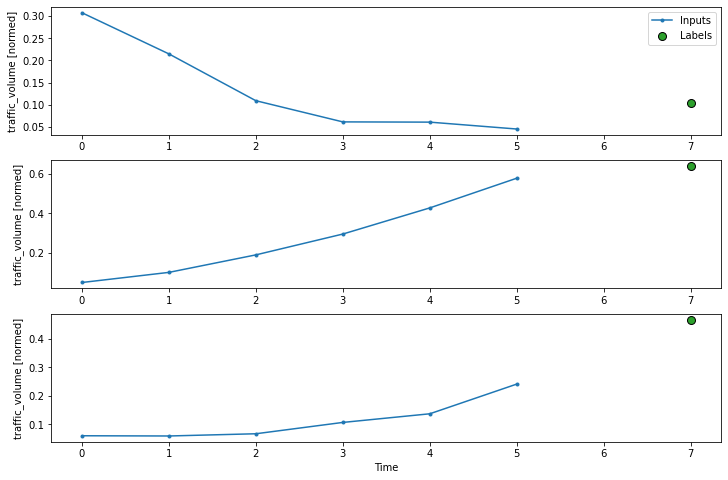

In [59]:
#Visualizing window setup for RNN/LSTM NN model
#Shows traffic volume value across the 6 input timesteps and true value of what model will predict
task_main.plot('traffic_volume')

## Baseline Model

The goal of this project is to develop a RNN/LSTM model that predicts traffic volume over a timeseries. In order to get sense of how different model architectures may perform, a simple RNN-LSTM baseline model will be used. This baseline model will consist of:

- Window size: 8, Input size: 6, Label shift: 2, Label width: 1, Model Stride= 1 (These will not change)
- Batch size 24  
- A single LSTM layer with 1 unit
- Activation function: Tanh
- Recurrent Activation: Sigmoid
- 1 unit Dense output layer

### Training Baseline: df_main

In [60]:
baseline = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(1, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [61]:
history= compile_and_fit(baseline, task_main)

Epoch 1/50
1440/1440 [==============================] - 8s 4ms/step - loss: 0.0556 - mean_absolute_error: 0.1759 - val_loss: 0.0233 - val_mean_absolute_error: 0.1173loss: 0.1062 - mean_absolut - ETA: 2s - loss:
Epoch 2/50
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0247 - mean_absolute_error: 0.1183 - val_loss: 0.0194 - val_mean_absolute_error: 0.1049
Epoch 3/50
1440/1440 [==============================] - 5s 4ms/step - loss: 0.0217 - mean_absolute_error: 0.1088 - val_loss: 0.0172 - val_mean_absolute_error: 0.0981loss: 0.0226 - - ETA: 2s - loss: 0.0224 - mean_absolute_error: 0.1 - ETA: 2s - loss: 0.0224 - mean_abs - ETA: 1s - loss: 0.0219 - mean_abso
Epoch 4/50
1440/1440 [==============================] - 5s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.1038 - val_loss: 0.0161 - val_mean_absolute_error: 0.0942loss: 0.0206 - mean_absol - ETA: 2s - loss: 0.0205 - mean_absolute_er - ETA: 2s - loss: 0.0206 - mean_absolute_error: 0. - ETA: 1s - loss: 0.0205 - mean_

1440/1440 [==============================] - 6s 4ms/step - loss: 0.0138 - mean_absolute_error: 0.0841 - val_loss: 0.0104 - val_mean_absolute_error: 0.0765 - mean_absolut - ETA: 1s - loss: 0.0138 - mean_abs - ETA: 0s - loss: 0.0138 - mean_absolute_erro
Epoch 39/50
1440/1440 [==============================] - 5s 4ms/step - loss: 0.0137 - mean_absolute_error: 0.0839 - val_loss: 0.0104 - val_mean_absolute_error: 0.0763ss: 0.0137 - mean_absolute_error: 0
Epoch 40/50
1440/1440 [==============================] - 5s 4ms/step - loss: 0.0137 - mean_absolute_error: 0.0837 - val_loss: 0.0104 - val_mean_absolute_error: 0.0761 mean_absolute - ETA: 1s - loss: 0.0136 - mean_absolute_error: 0. - ETA: 1s - loss: 0.0136 - mean_absolute_error:  - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.083 - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0 - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0
Epoch 41/50
1440/1440 [==============================] - 5s 4ms/step - loss: 0.0136 - mean_absolute_error: 0.08

#### Evaluating the baseline performance: df_main

360/360 - 0s - loss: 0.0101 - mean_absolute_error: 0.0751 - 423ms/epoch - 1ms/step
valid_mae=0.0751025602221489, valid_loss=0.01012086495757103


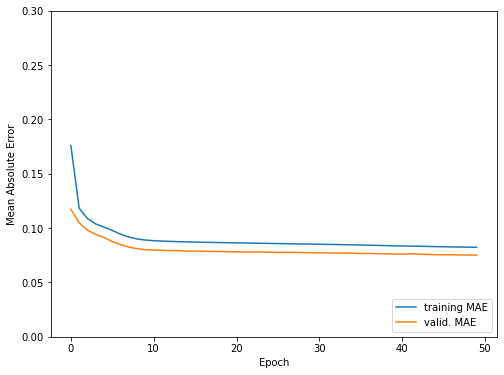

In [62]:
#Evaluating model
plt.plot(history.history['mean_absolute_error'], label='training MAE')
plt.plot(history.history['val_mean_absolute_error'], label = 'valid. MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.ylim([0, .3])
plt.legend(loc='lower right')

# Evaluate the learned model with validation set
valid_loss, valid_mae = baseline.evaluate(task_main.val, verbose=2) 
print ("valid_mae=%s, valid_loss=%s" % (valid_mae, valid_loss))

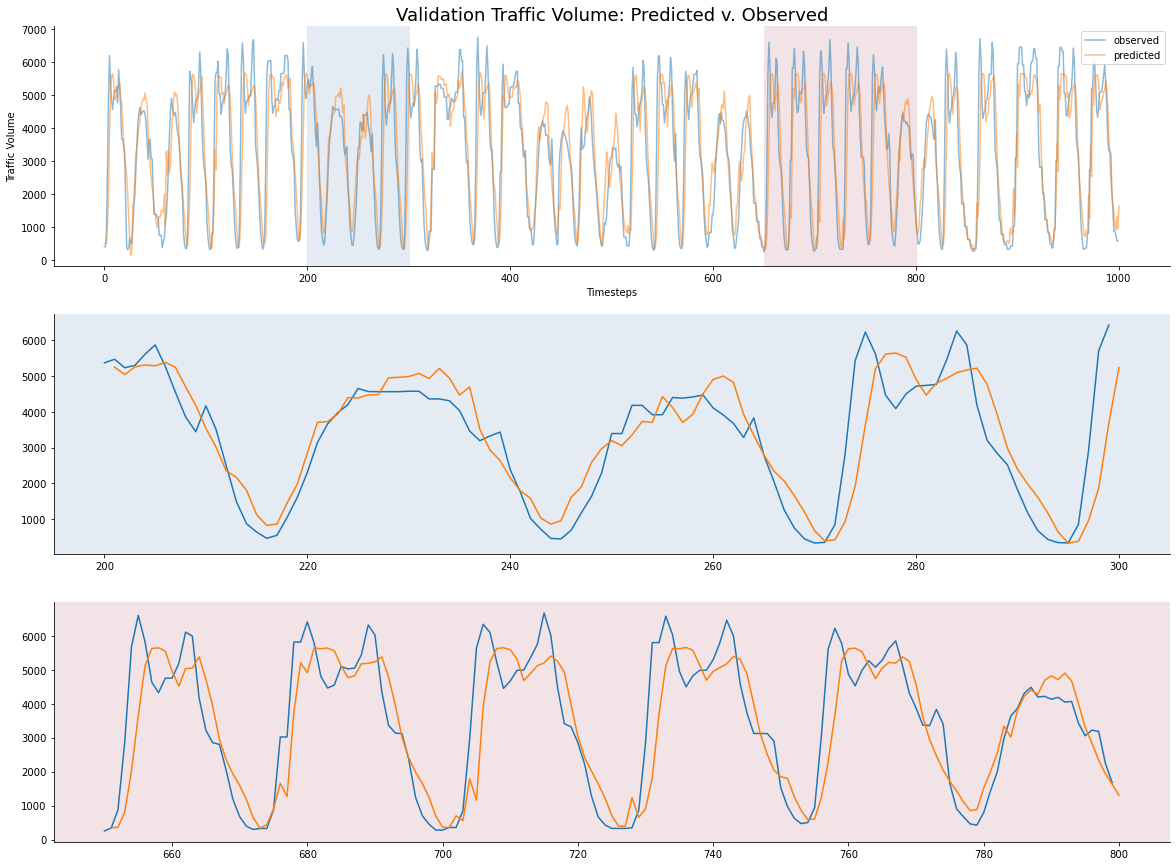

In [179]:
#Visualizing Predictions and True values of validation data using baseline model
val_pred= baseline.predict(task_main.val)
pv= pd.DataFrame(val_pred, index= list(range(1,len(val_pred)+1)), columns= ['prediction'])
pv= (pv * mm_range['traffic_volume']) + train_min['traffic_volume']

#First 7 timesteps have no predictions as a result of window size
v= val_df_main['traffic_volume'][7:].reset_index(drop=True)
v= (v * mm_range['traffic_volume']) + train_min['traffic_volume']

#Visualizing predicted traffic volume against observed traffic volumes for test data
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3, ncols=1, figsize=(20,15))
ax1.plot(v[:1000], alpha=.5, label='observed')
ax1.plot(pv[:1000], alpha=.5, label='predicted')
ax1.axvspan(200,300, color='#d9e3ed', alpha=.7)
ax1.axvspan(650,800, color='#edd9dc', alpha=.7)
ax1.set_title('Validation Traffic Volume: Predicted v. Observed', size=18)
ax1.set_ylabel('Traffic Volume')
ax1.set_xlabel('Timesteps')
ax1.legend(loc='upper right')
for location in ['right', 'top']:
    ax1.spines[location].set_visible(False)

ax2.plot(v[200:300], label='observed')
ax2.plot(pv[200:300], label='predicted')
ax2.patch.set_facecolor('#d9e3ed')
ax2.patch.set_alpha(.7)
for location in ['right', 'top']:
    ax2.spines[location].set_visible(False)

ax3.plot(v[650:800], label='observed')
ax3.plot(pv[650:800], label='predicted')
ax3.patch.set_facecolor('#edd9dc')
ax3.patch.set_alpha(.7)
for location in ['right', 'top']:
    ax3.spines[location].set_visible(False)
    
plt.show()

The baseline model produced a validation MAE's in a range .0713-.0790. The following section will setup trials to optimize model performance and improve MAE compared to the baseline.

## Optimization Trials

Different model hyperparameters were adjusted over several trials to evaluate impact on performance. Some of the hyperparameter tuning included batch size, number of nodes within layers, number of layers, layer types, and more. The mean absolute error when the model was applied to validation data for some of these trials follows:

**Baseline Validation MAE: .07 - .08**

**Evaluating batch size** <br>
Trial 1, Batch size 24: .0532

Trial 2, Batch size 48: .0557

**Evaluating Recurrent Units** <br>
Trial 3, 64 units: .0502

Trial 4, 128 units: .0504

Trial 5, 48 units: .0485

**Evaluating Stacked Recurrent Layers** <br>
Trial 6, 2 layers, 48 units: .0470

Trial 7, 3 layers, 48 units: .0471

**Evaluating 1D Convolution + RNN** <br>
Trial 8, 1 conv(32) + 2 RNN(48): .0475

Trial 9, 1 conv(32) + 2 RNN (48, 64): .0456

Trial 10, 1 conv(24) + 2 RNN (48,48): .0449

**Trial 11, 1 conv(12) + 2 RNN (24,48): .0442 Best Model**

The best performing model on the validation data was applied to the testing data and submitted for the kaggle competition. This model achieved 8th out of 46 entries in test performance. 

### Best Model

In [195]:
trial = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(12, kernel_size=3),
    tf.keras.layers.LSTM(24, return_sequences=True),
    tf.keras.layers.LSTM(48, return_sequences=False),
    tf.keras.layers.Dense(1, kernel_initializer= tf.keras.initializers.zeros())
])

In [196]:
history= compile_and_fit(trial, task_main)

Epoch 1/50
8639/8639 [==============================] - 52s 6ms/step - loss: 0.0231 - mean_absolute_error: 0.1067 - val_loss: 0.0082 - val_mean_absolute_error: 0.0662
Epoch 2/50
8639/8639 [==============================] - 46s 5ms/step - loss: 0.0100 - mean_absolute_error: 0.0677 - val_loss: 0.0065 - val_mean_absolute_error: 0.0572
Epoch 3/50
8639/8639 [==============================] - 47s 5ms/step - loss: 0.0087 - mean_absolute_error: 0.0618 - val_loss: 0.0063 - val_mean_absolute_error: 0.0547
Epoch 4/50
8639/8639 [==============================] - 48s 6ms/step - loss: 0.0082 - mean_absolute_error: 0.0591 - val_loss: 0.0061 - val_mean_absolute_error: 0.0540
Epoch 5/50
8639/8639 [==============================] - 47s 5ms/step - loss: 0.0078 - mean_absolute_error: 0.0575 - val_loss: 0.0059 - val_mean_absolute_error: 0.0533
Epoch 6/50
8639/8639 [==============================] - 47s 5ms/step - loss: 0.0076 - mean_absolute_error: 0.0563 - val_loss: 0.0057 - val_mean_absolute_error: 0.052

2159/2159 - 3s - loss: 0.0053 - mean_absolute_error: 0.0503 - 3s/epoch - 2ms/step
valid_mae=0.05034271627664566, valid_loss=0.005261357873678207


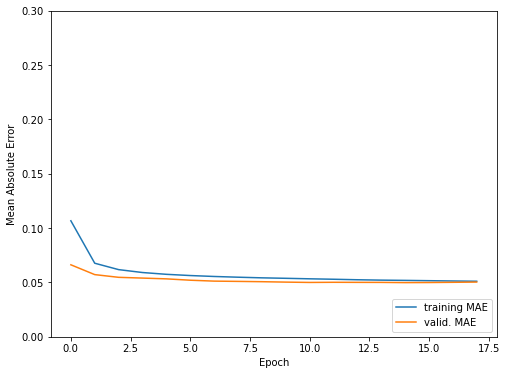

In [197]:
#Evaluating model
plt.plot(history.history['mean_absolute_error'], label='training MAE')
plt.plot(history.history['val_mean_absolute_error'], label = 'valid. MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.ylim([0, .3])
plt.legend(loc='lower right')

# Evaluate the learned model with validation set
valid_loss, valid_mae = trial.evaluate(task_main.val, verbose=2) 
print ("valid_mae=%s, valid_loss=%s" % (valid_mae, valid_loss))

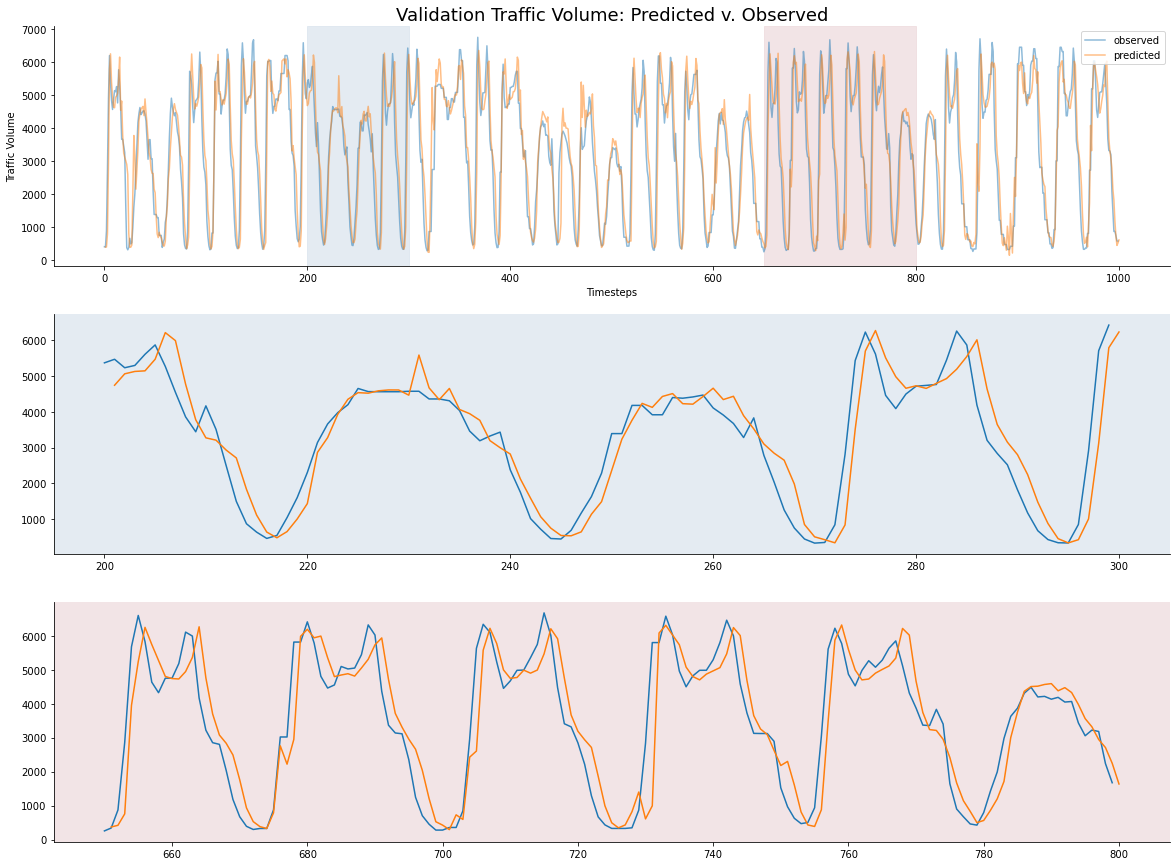

In [198]:
#Visualizing Predictions and True values of validation data using baseline model
val_pred= trial.predict(task_main.val)
pv= pd.DataFrame(val_pred, index= list(range(1,len(val_pred)+1)), columns= ['prediction'])
pv= (pv * mm_range['traffic_volume']) + train_min['traffic_volume']

#First 7 timesteps have no predictions as a result of window size
v= val_df_main['traffic_volume'][7:].reset_index(drop=True)
v= (v * mm_range['traffic_volume']) + train_min['traffic_volume']

#Visualizing predicted traffic volume against observed traffic volumes for test data
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3, ncols=1, figsize=(20,15))
ax1.plot(v[:1000], alpha=.5, label='observed')
ax1.plot(pv[:1000], alpha=.5, label='predicted')
ax1.axvspan(200,300, color='#d9e3ed', alpha=.7)
ax1.axvspan(650,800, color='#edd9dc', alpha=.7)
ax1.set_title('Validation Traffic Volume: Predicted v. Observed', size=18)
ax1.set_ylabel('Traffic Volume')
ax1.set_xlabel('Timesteps')
ax1.legend(loc='upper right')
for location in ['right', 'top']:
    ax1.spines[location].set_visible(False)

ax2.plot(v[200:300], label='observed')
ax2.plot(pv[200:300], label='predicted')
ax2.patch.set_facecolor('#d9e3ed')
ax2.patch.set_alpha(.7)
for location in ['right', 'top']:
    ax2.spines[location].set_visible(False)
    
ax3.plot(v[650:800], label='observed')
ax3.plot(pv[650:800], label='predicted')
ax3.patch.set_facecolor('#edd9dc')
ax3.patch.set_alpha(.7)
for location in ['right', 'top']:
    ax3.spines[location].set_visible(False)
    
plt.show()

## Test Predictions

In [199]:
#Make predictions on test data
predictions= trial.predict(task_main.test)

In [200]:
#De-Normalize the traffic volume predictions
p= pd.DataFrame(predictions, index= list(range(1,len(predictions)+1)), columns= ['prediction'])

#Normalized traffic volume predictions of test data
pnorm= p['prediction'].copy().reset_index(drop=True)

#De-Normalized traffic volume predictions of test data
p= (pnorm * mm_range['traffic_volume']) + train_min['traffic_volume']

In [201]:
o= test_df_main['traffic_volume']

#Normalized True Values of test data
#First 7 observations are disregarded because the model does not have the data to predict these values
onorm= o[7:].reset_index(drop=True)

#De-Normalized True values of test data
o= (onorm * mm_range['traffic_volume']) + train_min['traffic_volume']

Calculating MAE of Model on Test Data

In [205]:
#Calculating Mean Absolute Error of best model using test data (normalized)
test_mae= np.abs(pnorm - onorm).mean()
print('MAE Test Data (Normalized): {}\n'.format(test_mae))

#Calculating Mean Absolute Error of best model using test data (not normalized)
test_mae= np.abs(p - o).mean()
print('MAE Test Data (Original Scale): {}'.format(test_mae))

MAE Test Data (Normalized): 0.04571567477005575

MAE Test Data (Original Scale): 332.81011369866786


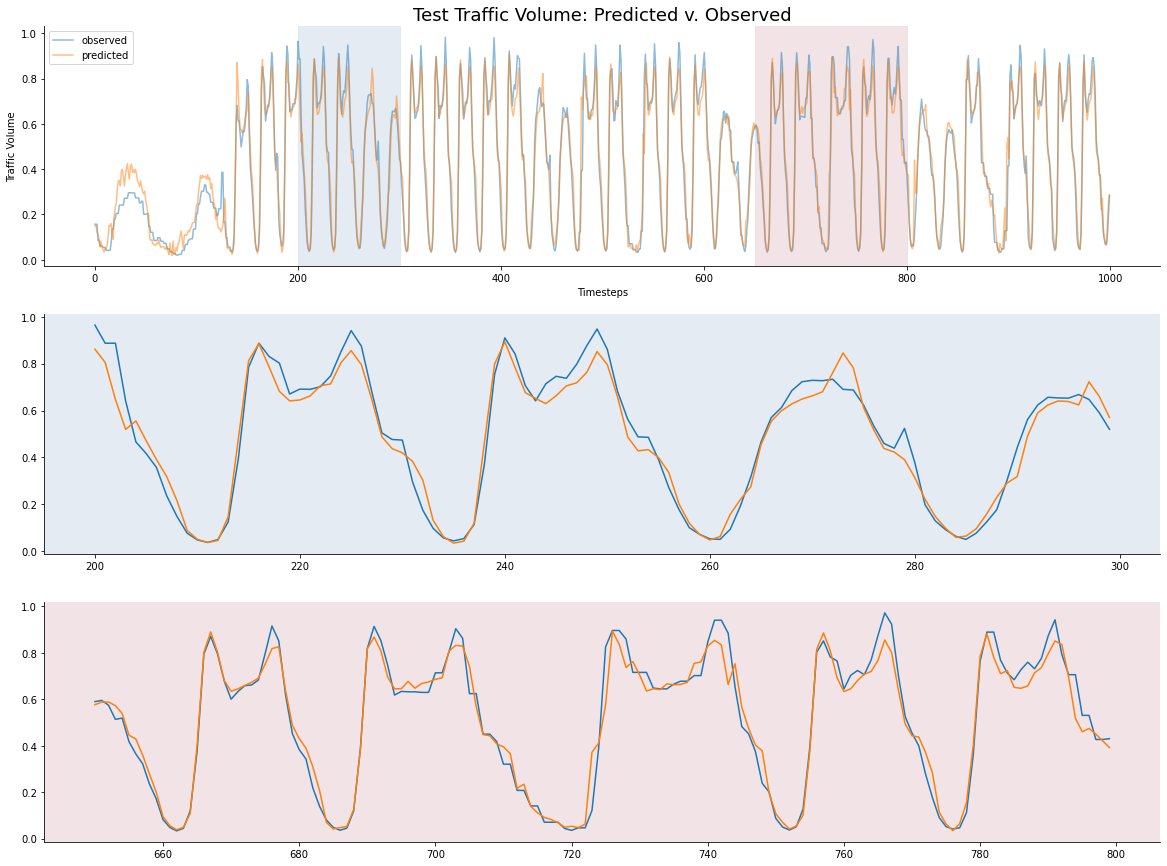

In [206]:
#Visualizing predicted traffic volume against observed traffic volumes for test data
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3, ncols=1, figsize=(20,15))
ax1.plot(onorm[:1000], alpha=.5, label='observed')
ax1.plot(pnorm[:1000], alpha=.5, label='predicted')
ax1.axvspan(200,300, color='#d9e3ed', alpha=.7)
ax1.axvspan(650,800, color='#edd9dc', alpha=.7)
ax1.set_title('Test Traffic Volume: Predicted v. Observed', size=18)
ax1.set_ylabel('Traffic Volume')
ax1.set_xlabel('Timesteps')
ax1.legend(loc='upper left')
for location in ['right', 'top']:
    ax1.spines[location].set_visible(False)

ax2.plot(onorm[200:300], label='observed')
ax2.plot(pnorm[200:300], label='predicted')
ax2.patch.set_facecolor('#d9e3ed')
ax2.patch.set_alpha(.7)
for location in ['right', 'top']:
    ax2.spines[location].set_visible(False)
    
ax3.plot(onorm[650:800], label='observed')
ax3.plot(pnorm[650:800], label='predicted')
ax3.patch.set_facecolor('#edd9dc')
ax3.patch.set_alpha(.7)
for location in ['right', 'top']:
    ax3.spines[location].set_visible(False)
    
plt.show()

The RNN/LSTM Neural Network model was able to predict traffic volume with a relatively high degree of accuracy. The predictions follow the trends of the actual traffic volume data rather well, and on average, deviate from the actual observed value by ~333 vehicles/hr. That number represents about 1/6th of a standard deviation.